In [5]:
from google.colab import files

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Libraries importation**

In [7]:
import os
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from textblob import TextBlob
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding
from keras.initializers import Constant
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.losses import mean_squared_error
from keras.callbacks import EarlyStopping
from sklearn.model_selection import KFold



In [8]:
%cd /content/drive/MyDrive/703_Project/LSTM/

/content/drive/MyDrive/703_Project/LSTM


**Create combined csv files**





In [ ]:
"""
def process_folder(main_folder_path, group_label):
   Traite tous les fichiers CSV dans un dossier et retourne un DataFrame fusionné.
    frames = []  # Liste pour stocker les DataFrames de chaque fichier
    for subdir, dirs, files in os.walk(main_folder_path):
      for filename in files:
        if filename.endswith('.csv'):
            file_path = os.path.join(subdir, filename)
            df = pd.read_csv(file_path)
            df['conversation_id'] = filename.split('.')[0]  # Utilisez le nom du fichier comme ID
            df['group'] = group_label
            df = df[['text', 'conversation_id', 'group']]
            frames.append(df)
    return pd.concat(frames)

# Chemins des dossiers pour les fichiers CSV des groupes contrôle et patient
control_main_folder_path = "Control_csv_data_clean"
patient_main_folder_path = "Patient_csv_data_clean"

# Traitement des dossiers et fusion des DataFrames
control_df = process_folder(control_main_folder_path, 'control')
patient_df = process_folder(patient_main_folder_path, 'patient')
combined_df = pd.concat([control_df, patient_df])

# Enregistrement du DataFrame fusionné dans un nouveau fichier CSV
combined_df.to_csv('combined_control_patient_data.csv', index=False)
"""

**Step 1 : data split and preprocessing**

>



In [30]:
# Charger les données
data = pd.read_csv('combined_control_patient_data.csv')
data_df = pd.DataFrame(data)

# Fonction de nettoyage des données textuelles
def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^a-zA-Z0-9']", " ", text)  # Supprimer les caractères non alphanumériques
    text = re.sub(r"\s+", " ", text)  # Supprimer les espaces supplémentaires
    return text

# Nettoyage du texte
data_df['text'] = data_df['text'].apply(clean_text)


# Fonction pour calculer le score de sentiment
def sentiment_score(text):
    analysis = TextBlob(text)
    return analysis.sentiment.polarity  # Retourne un score entre -1 et 1

# Appliquer la fonction à chaque réponse
data_df['sentiment'] = data_df['text'].apply(sentiment_score)

# Groupement des données par conversation_id
conversation_ids = data['conversation_id'].unique()
np.random.shuffle(conversation_ids)

# Division des identifiants de conversation
train_size = int(0.8 * len(conversation_ids))
val_size = int(0.1 * len(conversation_ids))

train_ids = conversation_ids[:train_size]
val_ids = conversation_ids[train_size:train_size + val_size]
test_ids = conversation_ids[train_size + val_size:]

# Sélection des ensembles d'entraînement, de validation et de test
train_df = data[data['conversation_id'].isin(train_ids)]
val_df = data[data['conversation_id'].isin(val_ids)]
test_df = data[data['conversation_id'].isin(test_ids)]

# Tokenisation et Padding
tokenizer = Tokenizer(num_words=12385)
tokenizer.fit_on_texts(data['text'])

# Fonction pour tokeniser et pad un DataFrame
max_seq_length = 15
def prepare_data(df):
    sequences = tokenizer.texts_to_sequences(df['text'])
    return pad_sequences(sequences, maxlen=max_seq_length)

# Préparation des données
X_train_padded = prepare_data(train_df)
y_train = train_df['sentiment'].values

X_val_padded = prepare_data(val_df)
y_val = val_df['sentiment'].values

X_test_padded = prepare_data(test_df)
y_test = test_df['sentiment'].values



In [ ]:
"""
data_sample_df['text'] = data_sample_df['text'].apply(clean_text)
sample_sequences = tokenizer.texts_to_sequences(data_sample_df['text'])
sample_padded = pad_sequences(sample_sequences, maxlen=max_seq_length)
"""

In [ ]:
"""
# examiner les séquences tokenisées et les longueurs de séquence
for i in range(5):
    print(f"Texte original: {data['text'].iloc[i]}")
    print(f"Séquence tokenisée: {sequences[i]}")
    print(f"Longueur de la séquence: {len(sequences[i])}\n")
"""

**How to get num_words and max_seq_length**

In [ ]:
# Tokenizer sans limiter le nombre de mots
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data_df['text'])

# Nombre total de mots uniques
word_count = len(tokenizer.word_index)
print(f"Nombre total de mots uniques dans le jeu de données : {word_count}")

Nombre total de mots uniques dans le jeu de données : 12385


In [ ]:
text_lengths = [len(text.split()) for text in data_df['text']]
print(f"Moyenne: {np.mean(text_lengths)}")
print(f"Médiane: {np.median(text_lengths)}")
print(f"Percentile 90: {np.percentile(text_lengths, 90)}")

Moyenne: 7.460360360360361
Médiane: 6.0
Percentile 90: 15.0


**Verifications**

In [ ]:
# Vérification des dimensions pour l'entraînement du modèle

print(f"Dimensions de X_train_padded: {X_train_padded.shape}")
print(f"Dimensions de y_train: {y_train.shape}")
print(f"Dimensions de X_test_padded: {X_test_padded.shape}")
print(f"Dimensions de y_test: {y_test.shape}")
print(f"Dimensions de X_val_padded: {X_val_padded.shape}")
print(f"Dimensions de y_val: {y_val.shape}")

Dimensions de X_train_padded: (64169, 15)
Dimensions de y_train: (64169,)
Dimensions de X_test_padded: (8008, 15)
Dimensions de y_test: (8008,)
Dimensions de X_val_padded: (6633, 15)
Dimensions de y_val: (6633,)


In [ ]:
print(f"Dimensions de ids_train: {train_ids.shape}")
print(f"Dimensions de ids_val: {val_ids.shape}")
print(f"Dimensions de ids_test: {test_ids.shape}")

Dimensions de ids_train: (357,)
Dimensions de ids_val: (44,)
Dimensions de ids_test: (46,)


**Step 2 : Word Embeddings preparation**

In [16]:
# Chargement des embeddings GloVe
EMBEDDING_DIM = 100  # Par exemple, pour GloVe 6B avec des vecteurs de 100 dimensions
embedding_index = {}
with open('glove.6B.100d.txt', 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coefs

# Préparation de la matrice d'embedding
embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, EMBEDDING_DIM))
for word, i in tokenizer.word_index.items():
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

# Création de la couche d'embedding en utilisant la matrice d'embedding
embedding_layer = Embedding(len(tokenizer.word_index) + 1,
                            EMBEDDING_DIM,
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=max_seq_length,
                            trainable=False)

In [ ]:
#contrôler la matrice d'embedding
print("Dimensions de la matrice d'embedding:", embedding_matrix.shape)

Dimensions de la matrice d'embedding: (12386, 100)


**Verifications**

In [ ]:
# Tokenizer Vocabulary
for word, index in tokenizer.word_index.items():
    print(f"Mot : {word}, Index : {index}")
    if index == 100:  # Afficher les 10 premiers mots
        break


In [ ]:
# Correspondence in the Embedding Matrix
for word, index in tokenizer.word_index.items():
    if word in embedding_index:
        print(f"Le mot '{word}' est dans GloVe.")
    else:
        print(f"Le mot '{word}' n'est pas dans GloVe.")
    if index == 100:  # Vérifier pour les 10 premiers mots
        break


In [ ]:
# Coverage %
total_mots = len(tokenizer.word_index)
mots_dans_glove = sum(1 for word in tokenizer.word_index if word in embedding_index)
pourcentage_couverture = (mots_dans_glove / total_mots) * 100
print(f"Pourcentage de mots du tokeniseur couverts par GloVe : {pourcentage_couverture}%")


Pourcentage de mots du tokeniseur couverts par GloVe : 89.01897456600727%


**Step 3 : LSTM model**

In [17]:
# Création du modèle LSTM
model = Sequential()
model.add(embedding_layer)  # Utilisez la couche d'embedding préparée précédemment
model.add(LSTM(128, return_sequences=False))  # return_sequences=False pour la dernière couche LSTM
model.add(Dropout(0.3))
model.add(Dense(1, activation='tanh'))  # Score de sentiment entre -1 et 1

model.compile(optimizer='adam', loss='mean_squared_error')


**Step 4 : Model training**

In [ ]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=10)

# Entraînement du modèle avec Early Stopping
model.fit(X_train_padded, y_train, epochs=25, batch_size=64, validation_data=(X_val_padded, y_val), callbacks=[early_stopping])
# results --> good behavior, good performance

Epoch 1/25
1003/1003 [==============================] - 50s 46ms/step - loss: 0.0306 - val_loss: 0.0177
Epoch 2/25
1003/1003 [==============================] - 41s 41ms/step - loss: 0.0183 - val_loss: 0.0130
Epoch 3/25
1003/1003 [==============================] - 43s 43ms/step - loss: 0.0145 - val_loss: 0.0105
Epoch 4/25
1003/1003 [==============================] - 46s 46ms/step - loss: 0.0117 - val_loss: 0.0085
Epoch 5/25
1003/1003 [==============================] - 42s 42ms/step - loss: 0.0100 - val_loss: 0.0076
Epoch 6/25
1003/1003 [==============================] - 44s 43ms/step - loss: 0.0087 - val_loss: 0.0067
Epoch 7/25
1003/1003 [==============================] - 41s 41ms/step - loss: 0.0078 - val_loss: 0.0063
Epoch 8/25
1003/1003 [==============================] - 41s 41ms/step - loss: 0.0071 - val_loss: 0.0061
Epoch 9/25
1003/1003 [==============================] - 41s 41ms/step - loss: 0.0064 - val_loss: 0.0058
Epoch 10/25
1003/1003 [==============================] - 41s 41m

**Step 5 : Model evaluation**

In [33]:
# Évaluation du Modèle sur l'Ensemble de Test
test_loss = model.evaluate(X_test_padded, y_test)
print(f"Perte sur l'ensemble de test: {test_loss}")


491/491 [==============================] - 8s 17ms/step - loss: 0.0044
Perte sur l'ensemble de test: 0.004400575999170542


In [34]:
# Prédiction des Sentiments sur l'Ensemble de Test
pred_sentiment = model.predict(X_test_padded)

491/491 [==============================] - 10s 19ms/step


In [35]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Calcul des métriques de régression
mse = mean_squared_error(y_test, pred_sentiment)
mae = mean_absolute_error(y_test, pred_sentiment)
rmse = np.sqrt(mse)

print(f"MSE(Mean Squared Error): {mse}, MAE(Mean Absolute Error): {mae}, RMSE(Root Mean Squared Error): {rmse}")
#low MSE --> the model, on average, predicts values ​​quite close to the actual values.
#low MAE --> low average error per prediction
#low RMSE --> low dispersion of errors in the model predictions
#the model gives relatively accurate predictions with low errors on the test set.


MSE(Mean Squared Error): 0.00440057495500335, MAE(Mean Absolute Error): 0.032226320567720505, RMSE(Root Mean Squared Error): 0.06633682955194158


**Contextualization**

In [ ]:
# Calcul de l'écart-type des scores de sentiment réels
ecart_type_sentiment = np.std(data_df['sentiment'])
print(f"Écart-type des scores de sentiment réels: {ecart_type_sentiment}")

# Moyenne absolue des scores de sentiment réels
moyenne_absolue_sentiment = np.mean(np.abs(data_df['sentiment']))
print(f"Moyenne absolue des scores de sentiment réels: {moyenne_absolue_sentiment}")

In [37]:

# Comparaison de l'RMSE avec l'écart-type
print(f"Le RMSE représente {(rmse / ecart_type_sentiment) * 100:.2f}% de l'écart-type des scores réels.")
# the errors of your sentiment prediction model are quite significant compared to the variability of the real data

Le RMSE représente 30.11% de l'écart-type des scores réels.


In [38]:
#Comparaison du MSE avec l'écart-type
print(f"Le MSE représente {(mse / ecart_type_sentiment**2) * 100:.2f}% de la variance des scores réels.")
# a small part of the variability in sentiment scores is due to your model's prediction errors --> the model is quite precise

# Comparaison du MAE avec la moyenne absolue
print(f"Le MAE représente {(mae / moyenne_absolue_sentiment) * 100:.2f}% de la moyenne absolue des scores réels.")
# the prediction errors, on average, are quite significant compared to the average deviation of the actual scores



Le MSE représente 9.07% de la variance des scores réels.
Le MAE représente 31.95% de la moyenne absolue des scores réels.


In [ ]:
# Graphique de dispersion
plt.scatter(y_test, pred_sentiment)
plt.xlabel('Valeurs Réelles')
plt.ylabel('Prédictions')
plt.title('Valeurs Réelles vs Prédictions')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')  # Ligne idéale
plt.show()

**Step 6 : Results**

In [39]:
# Créer un DataFrame pour associer les prédictions aux conversations
test_df['predicted_sentiment'] = pred_sentiment.flatten()

# Grouper par conversation_id
conversations = test_df.groupby('conversation_id')
evolution_sentiments = {}

for conversation_id, group in conversations:
    sentiment_debut = group['predicted_sentiment'].iloc[0]
    sentiment_fin = group['predicted_sentiment'].iloc[-1]
    evolution_sentiments[conversation_id] = sentiment_fin - sentiment_debut

evolutions_patient = [evolution_sentiments[cid] for cid, group in conversations if group['group'].iloc[0] == 'patient']
evolutions_control = [evolution_sentiments[cid] for cid, group in conversations if group['group'].iloc[0] == 'control']

<ipython-input-39-d6b5f769083e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['predicted_sentiment'] = pred_sentiment.flatten()


In [ ]:
test_df.columns

Index(['text', 'conversation_id', 'group', 'sentiment', 'predicted_sentiment'], dtype='object')

In [40]:
test_df.to_csv('test_df.csv', index="False")

**Variation totale du sentiment**

In [41]:
# Initialisation des variables pour accumuler les variations
variation_totale = {}
variation_totale_patient = []
variation_totale_controle = []
nombre_conversations_patient = 0
nombre_conversations_controle = 0

for conversation_id, group in conversations:
    # Calcul de la variation du sentiment pour la conversation
    variation = group['predicted_sentiment'].iloc[-1] - group['predicted_sentiment'].iloc[0]
    variation_totale[conversation_id] = variation

    # Compter le nombre de conversations pour chaque groupe
    if group['group'].iloc[0] == 'patient':
        nombre_conversations_patient += 1
        variation_totale_patient.append(variation)
    elif group['group'].iloc[0] == 'control':
        nombre_conversations_controle += 1
        variation_totale_controle.append(variation)

# Calcul des moyennes
moyenne_variation_patient = np.mean(variation_totale_patient)
moyenne_variation_controle = np.mean(variation_totale_controle)

print(f"Moyenne de la variation pour les patients: {moyenne_variation_patient}")
print(f"Moyenne de la variation pour les contrôles: {moyenne_variation_controle}")

print("Variations Totales par Conversation:", variation_totale)
print("Nombre de Conversations - Patient:", nombre_conversations_patient)
print("Nombre de Conversations - Control:", nombre_conversations_controle)



Moyenne de la variation pour les patients: -0.2011728584766388
Moyenne de la variation pour les contrôles: -0.14747031033039093
Variations Totales par Conversation: {'57-1': -0.4753898, '77-2': -0.58543944, 'Baycrest10599a': -0.36202195, 'Baycrest11752a': -0.8639724, 'Baycrest12073a': -1.1705257, 'Baycrest2571a': -0.3900237, 'Baycrest6819a': -0.79176116, 'MSUC03a': 0.836847, 'MSUC04b': -0.086972155, 'UMD01': -0.4524585, 'UMD03': -0.48971972, 'UMD04': -0.30953228, 'UMD10': -0.48821282, 'UMD12': -0.48410338, 'UMD21': -0.16882557, 'adler02a': 0.6734761, 'adler03a': -0.5094954, 'adler15a': -0.87579024, 'adler19a': -0.011541871, 'kurland01a': -0.01565592, 'kurland02f': -0.07181149, 'kurland04b': 0.12615913, 'kurland09d': -0.013827095, 'kurland12a': -0.0037524616, 'kurland13a': 0.008865248, 'kurland15a': -0.064668335, 'kurland15d': -0.027857494, 'kurland17c': -0.67110956, 'kurland18a': -0.49501234, 'kurland19b': 0.0, 'kurland21b': -0.49886084, 'kurland22a': 0.033121645, 'kurland23c': -0.5079

**Visualisation graphique**

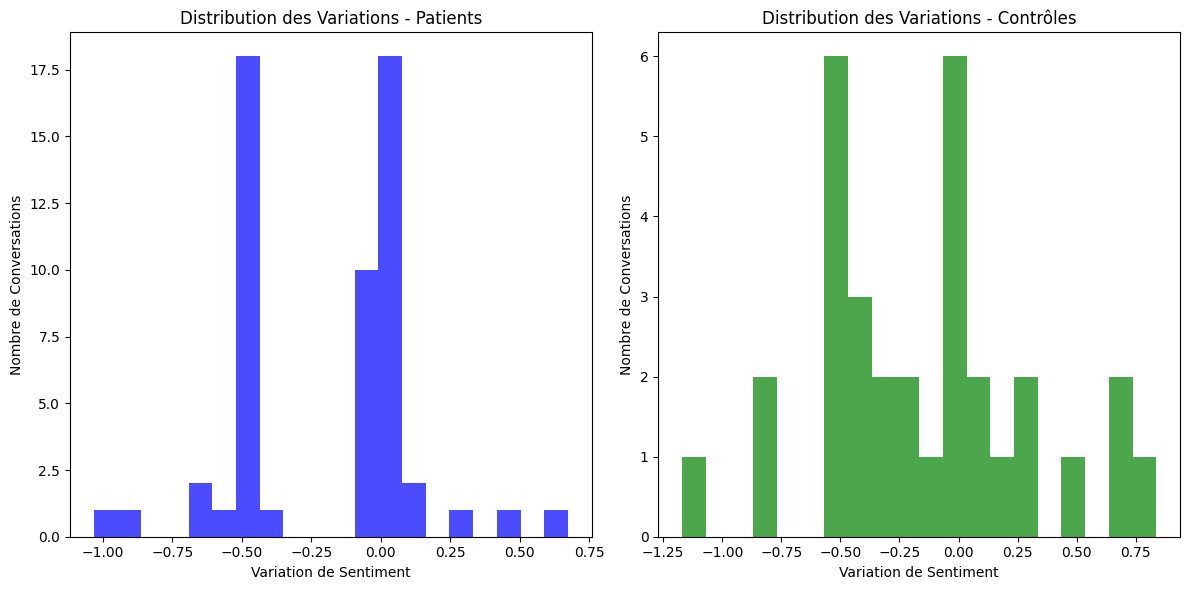

In [42]:
import matplotlib.pyplot as plt

# Histogramme des variations de sentiment
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(variation_totale_patient, bins=20, color='blue', alpha=0.7)
plt.title("Distribution des Variations - Patients")
plt.xlabel("Variation de Sentiment")
plt.ylabel("Nombre de Conversations")

plt.subplot(1, 2, 2)
plt.hist(variation_totale_controle, bins=20, color='green', alpha=0.7)
plt.title("Distribution des Variations - Contrôles")
plt.xlabel("Variation de Sentiment")
plt.ylabel("Nombre de Conversations")

plt.tight_layout()
plt.show()

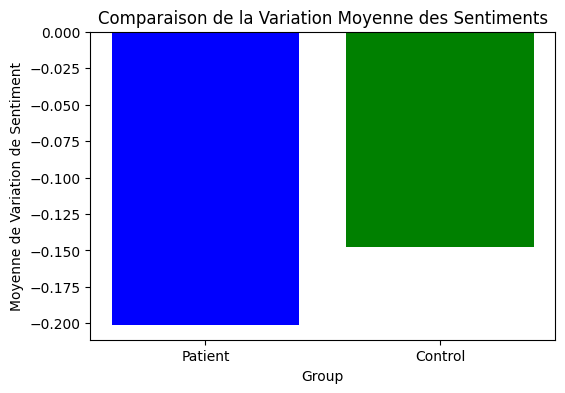

In [43]:
# Comparaison des moyennes des variations
plt.figure(figsize=(6, 4))
groupes = ['Patient', 'Control']
moyennes = [moyenne_variation_patient, moyenne_variation_controle]

plt.bar(groupes, moyennes, color=['blue', 'green'])
plt.xlabel('Group')
plt.ylabel('Moyenne de Variation de Sentiment')
plt.title('Comparaison de la Variation Moyenne des Sentiments')
plt.show()


**Static analysis**

In [ ]:
#variation_patient_sqrt = np.sqrt(np.array(variation_totale_patient) + 1)


In [ ]:

#shapiro_test_patient_transformed = stats.shapiro(variation_patient_sqrt)  # Ou variation_patient_box_cox, variation_patient_sqrt
#print(f"Shapiro Test après transformation: Statistique={shapiro_test_patient_transformed[0]}, p-value={shapiro_test_patient_transformed[1]}")


Shapiro Test après transformation: Statistique=0.9239652156829834, p-value=0.038470104336738586


In [45]:
# check the normality
import scipy.stats as stats

# Test de Shapiro-Wilk pour vérifier la normalité
# Pour le groupe patient
shapiro_test_patient = stats.shapiro(variation_totale_patient)
print(f"Shapiro Test pour le groupe patient: Statistique={shapiro_test_patient[0]}, p-value={shapiro_test_patient[1]}")

# Pour le groupe contrôle
shapiro_test_controle = stats.shapiro(variation_totale_controle)
print(f"Shapiro Test pour le groupe contrôle: Statistique={shapiro_test_controle[0]}, p-value={shapiro_test_controle[1]}")


Shapiro Test pour le groupe patient: Statistique=0.8898577094078064, p-value=8.568270277464762e-05
Shapiro Test pour le groupe contrôle: Statistique=0.9697996973991394, p-value=0.4938863515853882


In [46]:
#check the homogeneity of variances
from scipy.stats import levene

# Test de Levene pour vérifier l'homogénéité des variances
stat, p_value = levene(variation_totale_patient, variation_totale_controle)

print(f"Test de Levene: Statistique={stat}, p-value={p_value}")

# variances are equal

Test de Levene: Statistique=2.896634928436465, p-value=0.09233571471997856


In [47]:
from scipy.stats import ttest_ind

# Effectuer un test t pour échantillons indépendants
t_stat, p_value = ttest_ind(variation_totale_patient, variation_totale_controle)

print(f"Test t pour échantillons indépendants: Statistique t={t_stat}, p-value={p_value}")

#p-value > 0.05 --> the difference between the means of the two groups is not statistically significant


Test t pour échantillons indépendants: Statistique t=-0.6389966460485572, p-value=0.5245039216921175


Test de Mann-Whitney U

In [48]:
from scipy.stats import mannwhitneyu

# Effectuer le test de Mann-Whitney U
u_statistic, p_value = mannwhitneyu(variation_totale_patient, variation_totale_controle, alternative='two-sided')

print(f"Test de Mann-Whitney U: U Statistique={u_statistic}, p-value={p_value}")
#-->  p-value pas de différence statistique significative entre les deux groupes

Test de Mann-Whitney U: U Statistique=856.5, p-value=0.6381792141166578


**Test Cross validation**

**Step 1 : Data preprocessing and split**

In [9]:
# load the data
data = pd.read_csv('combined_control_patient_data.csv')
data_df = pd.DataFrame(data) # DataFrame

In [10]:
# Text data cleaning function
def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^a-zA-Z0-9']", " ", text) # Remove non-alphanumeric characters
    text = re.sub(r"\s+", " ", text)  # Remove extra white spaces
    return text

# Text cleaning
data_df['text'] = data_df['text'].apply(clean_text)

In [11]:
# Function to calculate sentiment score
def sentiment_score(text):
    analysis = TextBlob(text) # Creating a TextBlob object from the given text
    return analysis.sentiment.polarity  # Returns the sentiment polarity calculated by TextBlob, he polarity is a floating-point score ranging from -1 (negative) to 1 (positive)

# Apply the sentiment score calculation function to each text in the 'text' column of the DataFrame
#The result is stored in a new column 'sentiment' in the DataFrame
data_df['sentiment'] = data_df['text'].apply(sentiment_score)

In [12]:
# Grouping data by conversation_id
conversation_ids = data['conversation_id'].unique() # Extract unique conversation IDs from the data
np.random.shuffle(conversation_ids) # Shuffle the conversation IDs for randomness

# Splitting conversation IDs for training, validation, and testing
train_size = int(0.8 * len(conversation_ids)) # 80 % of data for training
#val_size = int(0.1 * len(conversation_ids)) # 10% of data for validation
test_size = int(0.2 * len(conversation_ids))  # 20% of data for testing

# Assigning conversation IDs to each dataset
train_ids = conversation_ids[:train_size] # IDs for training set
#val_ids = conversation_ids[train_size:train_size + val_size] #IDs for validation set
test_ids = conversation_ids[train_size:] #IDS for test set

# Selecting the training, validation, and test sets based on conversation IDs
train_df = data[data['conversation_id'].isin(train_ids)] # Training data frame
#val_df = data[data['conversation_id'].isin(val_ids)] # Validation data frame
test_df = data[data['conversation_id'].isin(test_ids)] #test data frame


In [13]:
# Tokenization and Padding
tokenizer = Tokenizer(num_words=12385) # Initialize tokenizer with a maximum number of words
tokenizer.fit_on_texts(data['text']) # Fit tokenizer on the text data

# Function to tokenize and pad a DataFrame
max_seq_length = 15 # Setting the maximum sequence length for padding
def prepare_data(df):
    sequences = tokenizer.texts_to_sequences(df['text']) # Tokenize the text
    return pad_sequences(sequences, maxlen=max_seq_length) # Return padded sequences


**How to get num_words and max_seq_length**

In [14]:
# Initializing a tokenizer without limiting the number of words
tokenizer = Tokenizer() # Create a new Tokenizer instance
tokenizer.fit_on_texts(data_df['text']) # Fit the tokenizer on the text data

# Calculating the total number of unique words in the dataset
word_count = len(tokenizer.word_index)  # Get the length of the word_index
print(f"Nombre total de mots uniques dans le jeu de données : {word_count}") # Print the total number of unique words

text_lengths = [len(text.split()) for text in data_df['text']]
print(f"Moyenne: {np.mean(text_lengths)}")
print(f"Médiane: {np.median(text_lengths)}")
print(f"Percentile 90: {np.percentile(text_lengths, 90)}")

Nombre total de mots uniques dans le jeu de données : 12385
Moyenne: 7.460360360360361
Médiane: 6.0
Percentile 90: 15.0


**Dimensions verification**

In [ ]:
#  dimensions of various data frame

print(f"Dimensions of X_train_padded: {X_train_padded.shape}")


print(f"Dimensions of y_train: {y_train.shape}")

print(f"Dimensions of X_test_padded: {X_test_padded.shape}")

print(f"Dimensions of y_test: {y_test.shape}")

print(f"Dimensions of X_val_padded: {X_val_padded.shape}")

print(f"Dimensions of y_val: {y_val.shape}")

print(f"Dimensions of train_ids: {train_ids.shape}")

print(f"Dimensions of val_ids: {val_ids.shape}")

print(f"Dimensions of test_ids: {test_ids.shape}")

**Step 2 : Word Embeddings preparation**

In [16]:
# Loading GloVe embeddings
EMBEDDING_DIM = 100  # for GloVe 6B with 100-dimensional vectors
embedding_index = {}
with open('glove.6B.100d.txt', 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coefs

# Preparing the embedding matrix
embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, EMBEDDING_DIM))
for word, i in tokenizer.word_index.items():
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

# Creating the embedding layer using the embedding matrix
embedding_layer = Embedding(len(tokenizer.word_index) + 1,
                            EMBEDDING_DIM,
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=max_seq_length,
                            trainable=False)

In [17]:
# control the embedding matrix
print("Embeddingx matrix dimension :", embedding_matrix.shape)

Embeddingx matrix dimension : (12386, 100)


**Coverage Verification**

In [18]:
# Calculating the percentage of words in the tokenizer that are covered by GloVe embeddings
total_words = len(tokenizer.word_index) # Get the total number of unique words in the tokenizer
words_in_glove = sum(1 for word in tokenizer.word_index if word in embedding_index) # Count how many of these words are present in the GloVe embeddings
coverage_percentage = (words_in_glove / total_words) * 100 # Calculate the coverage percentage: the ratio of words in GloVe to the total words in the tokenizer
print(f"Percentage of tokenizer words covered by GloVe : {coverage_percentage}%")
# 89 % --> good coverage

Percentage of tokenizer words covered by GloVe : 89.01897456600727%


**Step 3 : LSTM implementation, training and Cross-Validation Methodology**

In [37]:
# Initialize fold number and number of folds for cross-validation
fold_no = 1
num_folds = 5
kfold = KFold(n_splits=num_folds, shuffle=True) # Create KFold object with 3 splits and shuffling
# Initialize early stopping callback
#early_stopping = EarlyStopping(monitor='val_loss', patience=10)
# Loop through each fold for cross-validation
for fold_no, (train_indices, test_indices) in enumerate(kfold.split(conversation_ids), start=1): # Extract train and test IDs for the current fold
    # creating an LSTM model and reinitialize it for each fold
    model = Sequential() # Initialize a sequential model
    model.add(embedding_layer)  # Use the previously prepared embedding layer
    model.add(LSTM(128, return_sequences=False))  # return_sequences=False for the last LSTM layer
    model.add(Dropout(0.5)) # Add a Dropout layer to prevent overfitting
    model.add(Dense(1, activation='tanh'))  # Sentiment score between -1 and 1
    model.compile(optimizer='adam', loss='mean_squared_error') # adam is a popular choice and the loss function is mean squared error, typical for regression problems

    # Extract train and test IDs for the current fold
    train_ids = conversation_ids[train_indices]
    test_ids = conversation_ids[test_indices]
    #val_ids = conversation_ids[val]

    # Select train and test DataFrame based on the conversation IDs
    train_df = data[data['conversation_id'].isin(train_ids)]
    test_df = data[data['conversation_id'].isin(test_ids)]
    #val_df = data[data['conversation_id'].isin(val_ids)]

    # Prepare data for training and testing
    X_train_padded = prepare_data(train_df)
    y_train = train_df['sentiment'].values

    X_test_padded = prepare_data(test_df)
    y_test = test_df['sentiment'].values

    #X_val_padded = prepare_data(val_df)
    #y_val = val_df['sentiment'].values

    # Model training for the current fold
    print(f'Training for fold {fold_no} ...')
    model.fit(X_train_padded, y_train, epochs=2, batch_size=64)

    # Model Evaluation on the test set
    test_loss = model.evaluate(X_test_padded, y_test)
    print(f'Perte sur l\'ensemble de test pour le fold {fold_no}: {test_loss}')

    # Increment the fold number
    fold_no = fold_no + 1


Training for fold 1 ...
Epoch 1/2
971/971 [==============================] - 40s 39ms/step - loss: 0.0310
Epoch 2/2
522/522 [==============================] - 6s 10ms/step - loss: 0.0164
Perte sur l'ensemble de test pour le fold 1: 0.01644360087811947
Training for fold 2 ...
Epoch 1/2
972/972 [==============================] - 44s 43ms/step - loss: 0.0328
Epoch 2/2
520/520 [==============================] - 7s 10ms/step - loss: 0.0148
Perte sur l'ensemble de test pour le fold 2: 0.014775244519114494
Training for fold 3 ...
Epoch 1/2
975/975 [==============================] - 41s 39ms/step - loss: 0.0311
Epoch 2/2
515/515 [==============================] - 9s 16ms/step - loss: 0.0158
Perte sur l'ensemble de test pour le fold 3: 0.015770895406603813
Training for fold 4 ...
Epoch 1/2
1006/1006 [==============================] - 47s 44ms/step - loss: 0.0316
Epoch 2/2
453/453 [==============================] - 11s 23ms/step - loss: 0.0143
Perte sur l'ensemble de test pour le fold 4: 0.01431

**Model evaluation**

In [39]:
# Predicting sentiments on the test set
pred_sentiment = model.predict(X_test_padded) # Use the model to predict sentiments for the padded test data

455/455 [==============================] - 9s 18ms/step


In [48]:
# Calculating regression metrics
pred_sentiment = pred_sentiment.flatten()
mse = mean_squared_error(y_test, pred_sentiment) # Calculate Mean Squared Error between actual and predicted values
mae = mean_absolute_error(y_test, pred_sentiment) # Calculate Mean Absolute Error between actual and predicted values
rmse = np.sqrt(mse) # Calculate Root Mean Squared Error

print(f"MSE(Mean Squared Error): {(mse)}, MAE(Mean Absolute Error): {(mae)}, RMSE(Root Mean Squared Error): {(rmse)}")
#low MSE --> the model, on average, predicts values ​​quite close to the actual values.
#low MAE --> low average error per prediction
#low RMSE --> low dispersion of errors in the model predictions
#the model gives relatively accurate predictions with low errors on the test set.


MSE(Mean Squared Error): 0.016513409093022346, MAE(Mean Absolute Error): 0.07063780154931704, RMSE(Root Mean Squared Error): 0.12850451469421387


**Contextualization of the metrics**

In [49]:
# Calculating the standard deviation of the actual sentiment score
std_dev_sentiment = np.std(data_df['sentiment'])
print(f"Standard deviation of actual sentiment scores: {std_dev_sentiment}")

# Calculating the mean absolute value of the actual sentiment scores
mean_abs_sentiment = np.mean(np.abs(data_df['sentiment']))
print(f"Mean absolute of actual sentiment scores: {mean_abs_sentiment}")

Standard deviation of actual sentiment scores: 0.2202848557326425
Mean absolute of actual sentiment scores: 0.10087772460610742


In [52]:
# Comparing RMSE with the standard deviation
print(f"Le RMSE représente { (rmse / std_dev_sentiment) * 100:.2f}% de l'écart-type des scores réels.")
# This indicates how significant the errors of your sentiment prediction model are compared to the variability of the real data
# the errors of your sentiment prediction model are quite significant compared to the variability of the real data

Le RMSE représente 58.34% de l'écart-type des scores réels.


In [54]:
# Comparing MSE with the standard deviation
print(f"The MSE represents {(mse / std_dev_sentiment**2) * 100:.2f}% de la variance des scores réels.")
# a small part of the variability in sentiment scores is due to your model's prediction errors --> the model is quite precise

The MSE represents 34.03% de la variance des scores réels.


In [55]:
# Comparing MAE with the mean absolute
print(f"The MAE represents {(mae / mean_abs_sentiment) * 100:.2f}% de la moyenne absolue des scores réels.")
# the prediction errors, on average, are quite significant compared to the average deviation of the actual scores



The MAE represents 70.02% de la moyenne absolue des scores réels.


**Graphic visualization**

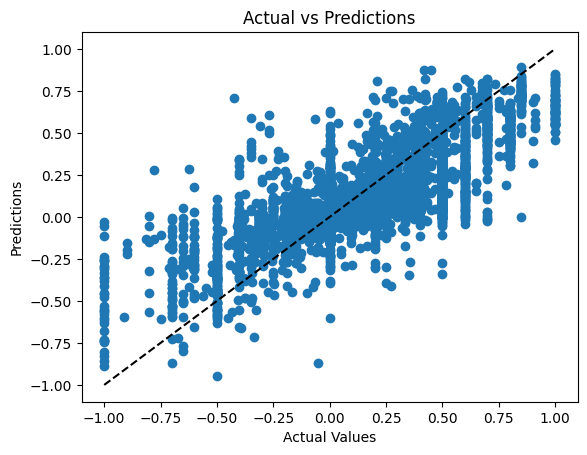

In [56]:
# Graphique de dispersion
plt.scatter(y_test, pred_sentiment)
plt.xlabel('Actual Values')
plt.ylabel('Predictions')
plt.title('Actual vs Predictions')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')  # ideal lign
plt.show()

In [57]:
# Creating a DataFrame to associate predictions with conversations
test_df['predicted_sentiment'] = pred_sentiment.flatten() # Add predicted sentiment scores to the test DataFrame

# Grouping by conversation_id
conversations = test_df.groupby('conversation_id') # Group the DataFrame by conversation_id
evolution_sentiments = {} # Initialize a dictionary to store the sentiment evolution for each conversation

for conversation_id, group in conversations:
    sentiment_debut = group['predicted_sentiment'].iloc[0] # Get the first (starting) sentiment prediction of the conversation
    sentiment_fin = group['predicted_sentiment'].iloc[-1] # Get the last (ending) sentiment prediction of the conversation
    evolution_sentiments[conversation_id] = sentiment_fin - sentiment_debut # Calculate the change in sentiment from start to end and store it in the dictionary

#evolutions_patient = [evolution_sentiments[cid] for cid, group in conversations if group['group'].iloc[0] == 'patient']
#evolutions_control = [evolution_sentiments[cid] for cid, group in conversations if group['group'].iloc[0] == 'control']

<ipython-input-57-116912a45b38>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['predicted_sentiment'] = pred_sentiment.flatten() # Add predicted sentiment scores to the test DataFrame


In [41]:
test_df.to_csv('test_df.csv', index="False")

In [58]:
# Initialize variables to accumulate variations
total_variation = {}
total_variation_patient = []
total_variation_control = []
num_conversations_patient = 0
num_conversations_control = 0

for conversation_id, group in conversations:
    # Calculate the sentiment variation for the conversation
    variation = group['predicted_sentiment'].iloc[-1] - group['predicted_sentiment'].iloc[0]
    total_variation[conversation_id] = variation

    # Count the number of conversations for each group
    if group['group'].iloc[0] == 'patient':
        num_conversations_patient += 1
        total_variation_patient.append(variation)
    elif group['group'].iloc[0] == 'control':
        num_conversations_control += 1
        total_variation_control.append(variation)

# Calculate averages
average_variation_patient = np.mean(total_variation_patient)
average_variation_control = np.mean(total_variation_control)

# Print average variations and conversation counts
print(f"Average variation for patients: {average_variation_patient}")
print(f"Average variation for controls: {average_variation_control}")

print("Total Variations by Conversation:", total_variation)
print("Number of Conversations - Patient:", num_conversations_patient)
print("Number of Conversations - Control:", num_conversations_control)


Average variation for patients: -0.21633294224739075
Average variation for controls: -0.0058143180795013905
Total Variations by Conversation: {'45-1': -0.30902183, '49-2': -0.3562507, '60-1': -0.5992693, '60-2': -0.6897944, '64-1': -0.49963155, '65-1': -0.16016668, '67-1': -0.17318413, '70-2': -0.73156494, '73-2': -0.013447229, '75-1': -0.038640693, '77-1': -0.025984533, 'Baycrest11257a': -0.6980872, 'Baycrest11752a': -0.7875139, 'Baycrest11841a': 0.45330858, 'Baycrest12269a': 0.0, 'Baycrest12272a': -0.3888363, 'Baycrest12370a': -0.8372587, 'MSUC01a': -0.0258634, 'MSUC05a': -0.052598476, 'MSUC05b': -0.0655469, 'MSUC07a': -0.34916732, 'UMD17': 0.055346556, 'UMD21': 0.32809746, 'adler03a': -0.6039555, 'adler04a': -1.1602417e-05, 'adler14a': -0.018153682, 'adler19a': 0.0065064, 'adler22a': -0.012615773, 'adler24a': -0.0018897802, 'kurland02b': -0.48817453, 'kurland06a': -0.6420429, 'kurland07c': 0.010450728, 'kurland10b': 0.6761099, 'kurland14a': -0.46658897, 'kurland15b': -0.006354708, '

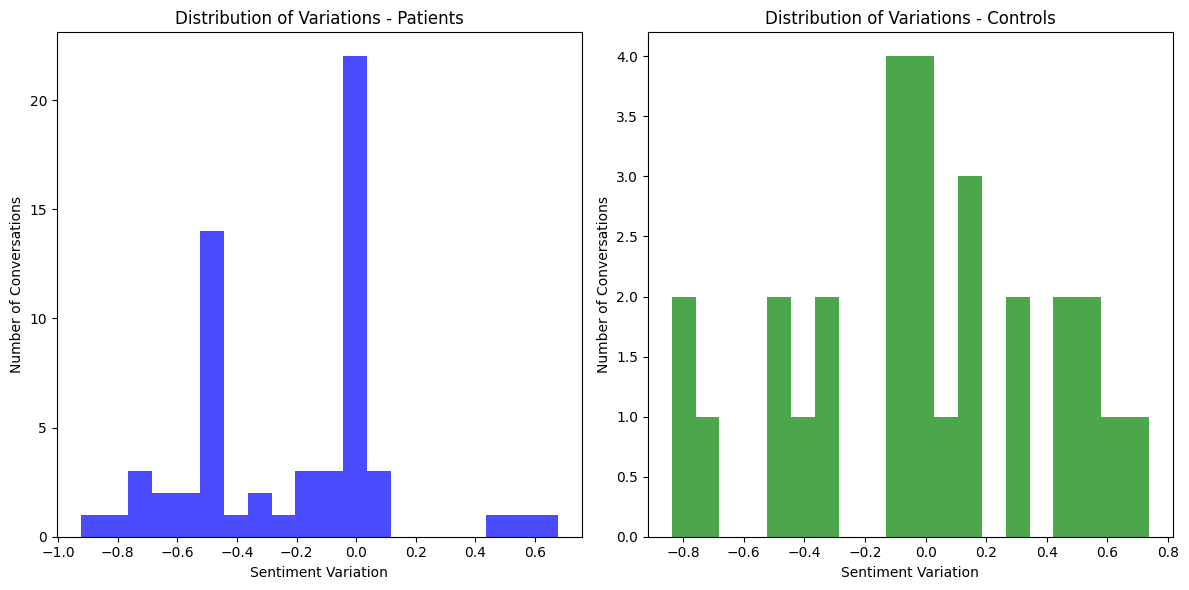

In [59]:
# Histogram of sentiment variations
plt.figure(figsize=(12, 6))

# Histogram for patients
plt.subplot(1, 2, 1)
plt.hist(total_variation_patient, bins=20, color='blue', alpha=0.7)
plt.title("Distribution of Variations - Patients")
plt.xlabel("Sentiment Variation")
plt.ylabel("Number of Conversations")

# Histogram for control group
plt.subplot(1, 2, 2)
plt.hist(total_variation_control, bins=20, color='green', alpha=0.7)
plt.title("Distribution of Variations - Controls")
plt.xlabel("Sentiment Variation")
plt.ylabel("Number of Conversations")

plt.tight_layout()
plt.show()

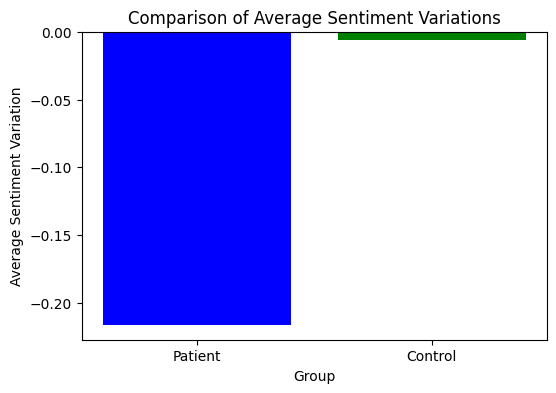

In [60]:
# Bar Chart
# Comparison of the average variations
plt.figure(figsize=(6, 4))
groups = ['Patient', 'Control']
averages = [average_variation_patient, average_variation_control]

# Creating a bar chart to compare the averages
plt.bar(groups, averages, color=['blue', 'green'])
plt.xlabel('Group')
plt.ylabel('Average Sentiment Variation')
plt.title('Comparison of Average Sentiment Variations')
plt.show()

In [61]:
# check the normal distribution
# Shapiro-Wilk to check if both groups follow a normal distribution
# patient group
shapiro_test_patient = stats.shapiro(total_variation_patient)
print(f"Shapiro Test for patient group: Statistic={shapiro_test_patient[0]}, p-value={shapiro_test_patient[1]}")

# control group
shapiro_test_control = stats.shapiro(total_variation_control)
print(f"Shapiro Test for control group : Statistic={shapiro_test_control[0]}, p-value={shapiro_test_control[1]}")


Shapiro Test for patient group: Statistic=0.9220333099365234, p-value=0.0008324756054207683
Shapiro Test for control group : Statistic=0.9673577547073364, p-value=0.5118076801300049


In [62]:
#check the homogeneity of variances
from scipy.stats import levene

# Levene's test to check for homogeneity of variances
stat, p_value = levene(total_variation_patient, total_variation_control)

print(f"Levene's Test : Statistic={stat}, p-value={p_value}")

# If p-value > 0.05, it suggests homogeneity of variances

Levene's Test : Statistic=1.0685495941133891, p-value=0.3041382116180743


In [63]:
from scipy.stats import ttest_ind

# Performing a t-test for independent samples
t_stat, p_value = ttest_ind(total_variation_patient, total_variation_control)

print(f"T-test for independent samples :  t-Statistic={t_stat}, p-value={p_value}")

#p-value > 0.05 --> the difference between the means of the two groups is not statistically significant
# If p-value > 0.05, it suggests that the difference between the means of the two groups is not statistically significant

T-test for independent samples :  t-Statistic=-2.5727751098939575, p-value=0.011783732810084225


In [64]:
from scipy.stats import mannwhitneyu

# Mann-Whitney U Test
u_statistic, p_value = mannwhitneyu(total_variation_patient, total_variation_control, alternative='two-sided')

print(f"TMann-Whitney U Test: U Statistic={u_statistic}, p-value={p_value}")
#-->  p-value >0.05 not significative statistic difference between the two groups
# If p-value > 0.05, it indicates no statistically significant difference between the two groups

TMann-Whitney U Test: U Statistic=591.0, p-value=0.02037833802096125
